<a href="https://colab.research.google.com/github/devxkrxshna/Denoising-Autoencoder/blob/main/DAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
dataiter = iter(data_loader) 
images, labels = dataiter.next() #pulling out the first images and labels by calling data iter
print(torch.min(images), torch.max(images)) #ranging from 0-1

tensor(0.) tensor(1.)


In [ ]:
# repeatedly reduce the size
class Autoencoder_Linear(nn.Module): #inheritance from nn.model
    def __init__(self):
        super().__init__()   
        #below code we are repeatedly reducing the size     
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), # (N, 784) -> (N, 128) , first linear layer
            nn.ReLU(),  #activation function
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # -> N, 3 #last layer
        )
        
        self.decoder = nn.Sequential( 
            nn.Linear(3, 12), #input size= 3, o/p size =12
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid() #our images have values between 0-1, sigmoid function push o/p o the range 0-1
        )

    def forward(self, x): #forward pass
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# Input [-1, +1] -> use nn.Tanh

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

In [ ]:
#set up the autoencoder
model = Autoencoder()

criterion = nn.MSELoss() #mean square error loss function, to adjust weight and bias
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5) #optimizer

In [ ]:
#function to add noise
def add_noise(inputs,noise_factor=0.3):
     noisy = inputs+torch.randn_like(inputs) * noise_factor
     noisy = torch.clip(noisy,0.,1.)
     return noisy

In [ ]:
# training loop
num_epochs = 1
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img_noisy = add_noise(img,noise_factor=0.3)
        #img = img.reshape(-1, 28*28) #  use for Autoencoder_Linear
        recon = model(img_noisy) #reconstructed image
        loss = criterion(recon, img_noisy) #call loss function to calculate the mean squared error between them
        
        optimizer.zero_grad() #gradient descent is set to zero, to prevent gradient would keep accumulating over time.


        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img,img_noisy, recon)) #storing

Epoch:1, Loss:0.0398


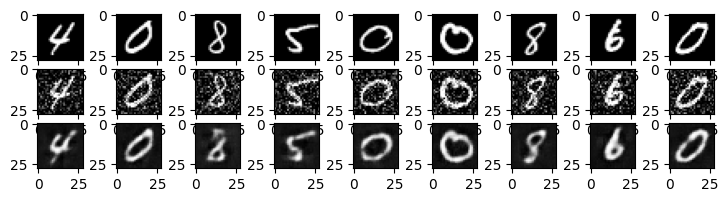

In [ ]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy() 
    imgs_noisy = outputs[k][2].detach().numpy()#converting a tensor to numpy
    recon = outputs[k][3].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break #plot the first 9 in a batch
        plt.subplot(3, 9, i+1) 
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
        
    for i, item in enumerate(imgs_noisy):
        if i >= 9: break
        plt.subplot(3, 9, 9+i+1) # row_length + i + 1
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])


    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(3, 9, 18+i+1) # total row_length + i + 1
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])